In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import FloatLogSlider, interact
from scipy.stats import gaussian_kde
from typing import Tuple

GRID_MIN: float = -6.0
GRID_MAX: float =  6.0
GRID_SIZE: int   = 1_000
N_SAMPLES: int   = 150

# true mixture parameters
MIX_MEANS:  np.ndarray = np.array([-3.0, 0.0, 2.5])
MIX_STDS:   np.ndarray = np.array([ 0.4, 0.8, 0.5])
MIX_WEIGHTS:np.ndarray = np.array([ 0.35, 0.40, 0.25])


In [13]:
def sample_mixture(n: int) -> pd.Series:
    component_choices: np.ndarray = np.random.choice(len(MIX_MEANS), size=n, p=MIX_WEIGHTS)
    samples: np.ndarray = np.random.normal(
        loc=MIX_MEANS[component_choices],
        scale=MIX_STDS[component_choices]
    )
    return pd.Series(samples, name='x')

def true_pdf(grid: np.ndarray) -> np.ndarray:
    pdf_vals: np.ndarray = np.zeros_like(grid)
    for μ, σ, w in zip(MIX_MEANS, MIX_STDS, MIX_WEIGHTS):
        pdf_vals += w * (1.0 / (np.sqrt(2.0 * np.pi) * σ)) * np.exp(-0.5 * ((grid - μ) / σ) ** 2)
    return pdf_vals

sample_series: pd.Series = sample_mixture(N_SAMPLES)
x_grid: np.ndarray = np.linspace(GRID_MIN, GRID_MAX, GRID_SIZE)
true_density: np.ndarray = true_pdf(x_grid)


In [14]:
def gaussian_kernel(u: np.ndarray) -> np.ndarray:
    return np.exp(-0.5 * u ** 2) / np.sqrt(2.0 * np.pi)

def kde_manual(sample: np.ndarray, bandwidth: float, grid: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    n: int = sample.size
    kernels: np.ndarray = np.zeros((n, grid.size))
    for idx, xi in enumerate(sample):
        kernels[idx, :] = gaussian_kernel((grid - xi) / bandwidth) / (n * bandwidth)
    return kernels, kernels.sum(axis=0)

def plot_kde_bandwidth(bandwidth: float) -> None:
    kernels, kde_vals = kde_manual(sample_series.values, bandwidth, x_grid)

    fig, ax = plt.subplots(figsize=(6, 4))
    # plot individual kernels
    for kernel in kernels:
        ax.plot(x_grid, kernel, color='grey', alpha=0.4, linewidth=1)

    # KDE
    ax.plot(x_grid, kde_vals, label=f'KDE (h={bandwidth:.3f})', linewidth=2)

    # true density
    ax.plot(x_grid, true_density, label='True PDF', linestyle='--', linewidth=2)

    # rug plot
    ax.plot(sample_series, np.zeros_like(sample_series) - 0.002,
            '|', markersize=10, color='black')

    ax.set_xlabel('x')
    ax.set_ylabel('density')
    ax.set_xlim(GRID_MIN, GRID_MAX)
    ax.set_ylim(0, true_density.max() * 1.1)
    ax.legend()
    ax.grid(True)
    plt.show()


In [15]:
bandwidth_slider: FloatLogSlider = FloatLogSlider(
    value=0.3, base=10, min=-1, max=0.3, step=0.05,
    description='Bandwidth (h)', continuous_update=False
)
interact(plot_kde_bandwidth, bandwidth=bandwidth_slider)


interactive(children=(FloatLogSlider(value=0.3, continuous_update=False, description='Bandwidth (h)', max=0.3,…

<function __main__.plot_kde_bandwidth(bandwidth: float) -> None>

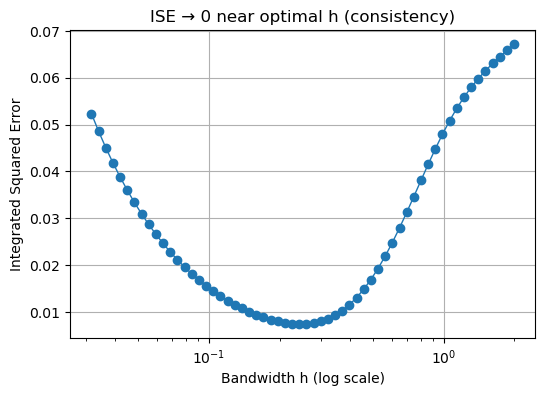

In [16]:
def ise(bandwidth: float) -> float:
    _, kde_vals = kde_manual(sample_series.values, bandwidth, x_grid)
    return np.trapezoid((kde_vals - true_density) ** 2, x_grid)

bandwidths: np.ndarray = np.logspace(-1.5, 0.3, 60)
ise_vals: np.ndarray = np.array([ise(h) for h in bandwidths])

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(bandwidths, ise_vals, marker='o', linewidth=1)
ax.set_xscale('log')
ax.set_xlabel('Bandwidth h (log scale)')
ax.set_ylabel('Integrated Squared Error')
ax.set_title('ISE → 0 near optimal h (consistency)')
ax.grid(True)
plt.show()
